# WFP - Ellip training over Nigeria

October 2019


The goal of this notebook is to:

- Discover and stage-in the COIN processing request generated results
- Plot a few layers 

**The Coherence and Intensity change** 

The coherence between an images pair can show if the images have strong similarities, represented in a scale from 0 to 1. Areas of high coherence will appear bright (values near 1). Areas with poor coherence will be dark (values near 0). For example, vegetation and water have poor coherence and buildings have very high coherence.

The intensity represents the strength of the radar response from the observed scene. Such intensity can vary dependent on changes occurred in time between the acquisitions and also on the scene physical characteristics.

To better detect the intensity change this service provides, in addition to the intensity in dB of the individual images, the dB average and dB difference of the image pair.

Also a couple of RGB composites are provided:

- An RGB image with:

 * Red -  Coherence
 * Green - Intensity average
 * Blue - Null 

Thanks to this representation is possible to show urban centres in yellow, which have high coherence and intensity. Green can represent vegetated fields and forests. The reds and oranges represent unchanging features such as bare soil or possibly rocks.

- An RGB image with:
 
 * Red - Slave Intensity
 * Green - Master Intensity
 * Blue - Master Intensity
 
Thanks to this representation is possible to clearly show inundated areas in cyan.


In [2]:
import sys
import os
import cioppy
sys.path.append(os.getcwd())
from wfp_nigeria_helpers import *
import gdal
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image

import getpass
%matplotlib inline

%load_ext autoreload
%autoreload 2

%store -r

### Authentication

In [42]:
if not 'username' in locals():
    username = raw_input('What is your Terradue username?')
    %store username

Stored 'username' (str)


Set the API key associated to the Terradue username. 

It is available at this link: https://www.terradue.com/portal/settings/apikey (it requires a login with the Terradue username)

In [43]:
if not 'api_key' in locals():
    api_key = getpass.getpass('And your Terradue API key:')
    %store api_key
   

Stored 'api_key' (str)


### Set the COIN processing information

In [3]:
if not 'coin_results_osd' in locals():
    coin_results_osd = getpass.getpass('The COIN results Opensearch Description Document URL:')
    %store coin_results_osd

In [4]:
#coin_results_osd = 'https://recast.terradue.com/t2api/describe/fbrito/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/7702c24c-dade-11e9-9fbf-0242ac110028/0016529-190318164522056-oozie-oozi-W'

Discover the results generated by the COIN service execution

In [3]:
search_results = gpd.GeoDataFrame(cioppy.Cioppy().search(end_point=coin_results_osd,
                                                         params=[],
                                                         output_fields='identifier,enclosure,title',
                                                         model='GeoTime',
                                                         timeout=50000))

In [4]:
search_results

,enclosure,identifier,title
0,https://store.terradue.com/fbrito/_results/wor...,A4FDD15A546E927D93DB7EE9FB5A5720CB380515,coh_sigmaAvrg_IW_VV_16Sep2018_11Sep2019_Coh_Ampl
1,https://store.terradue.com/fbrito/_results/wor...,2ED3824924FAC4276E18E34B2F8210F22F5443FC,coherence_IW_VV_16Sep2018_11Sep2019
2,https://store.terradue.com/fbrito/_results/wor...,BA7FC87587EEF071457ED554116ACDDC18942FD2,sigmaAverage_dB_IW_VV_16Sep2018_11Sep2019
3,https://store.terradue.com/fbrito/_results/wor...,5A0D3C94B0643D721B7B09A92EB6BD7A79819493,sigmaDiff_dB_IW_VV_16Sep2018_11Sep2019
4,https://store.terradue.com/fbrito/_results/wor...,F143F440DDBB1BC8E27747DB2E1FD88308E0EB0B,sigmaMaster_dB_IW_VV_16Sep2018
5,https://store.terradue.com/fbrito/_results/wor...,DBE3EF8FFDFB72C47AD2649240228302A41E5B9A,sigmaSlave_dB_11Sep2019_sigmaMaster_dB_16Sep20...
6,https://store.terradue.com/fbrito/_results/wor...,0E1027FD8EDAEFF4435DE6FF1F39C310DFDC2FDD,sigmaSlave_dB_IW_VV_11Sep2019


In [5]:
search_results.title.values

array(['coh_sigmaAvrg_IW_VV_16Sep2018_11Sep2019_Coh_Ampl',
       'coherence_IW_VV_16Sep2018_11Sep2019',
       'sigmaAverage_dB_IW_VV_16Sep2018_11Sep2019',
       'sigmaDiff_dB_IW_VV_16Sep2018_11Sep2019',
       'sigmaMaster_dB_IW_VV_16Sep2018',
       'sigmaSlave_dB_11Sep2019_sigmaMaster_dB_16Sep2018_IW_VV_Ampl_Change',
       'sigmaSlave_dB_IW_VV_11Sep2019'], dtype=object)

In [6]:
search_results[(search_results.title.str.contains('Ampl_Change')) | (search_results.title.str.contains('Coh_Ampl'))]

,enclosure,identifier,title
0,https://store.terradue.com/fbrito/_results/wor...,A4FDD15A546E927D93DB7EE9FB5A5720CB380515,coh_sigmaAvrg_IW_VV_16Sep2018_11Sep2019_Coh_Ampl
5,https://store.terradue.com/fbrito/_results/wor...,DBE3EF8FFDFB72C47AD2649240228302A41E5B9A,sigmaSlave_dB_11Sep2019_sigmaMaster_dB_16Sep20...


#### Download result for an area of interest

In [7]:
aoi_bbox = '5.743,13.017,5.811,13.08'

In [8]:
aoi = [float(coord) for coord in aoi_bbox.split(',')]

In [9]:
aoi

[5.743, 13.017, 5.811, 13.08]

coh_sigmaAvrg_IW_VV_16Sep2018_11Sep2019_Coh_Ampl
(713, 750, 4)
sigmaDiff_dB_IW_VV_16Sep2018_11Sep2019
(701, 757, 1)
sigmaSlave_dB_11Sep2019_sigmaMaster_dB_16Sep2018_IW_VV_Ampl_Change
(713, 750, 4)


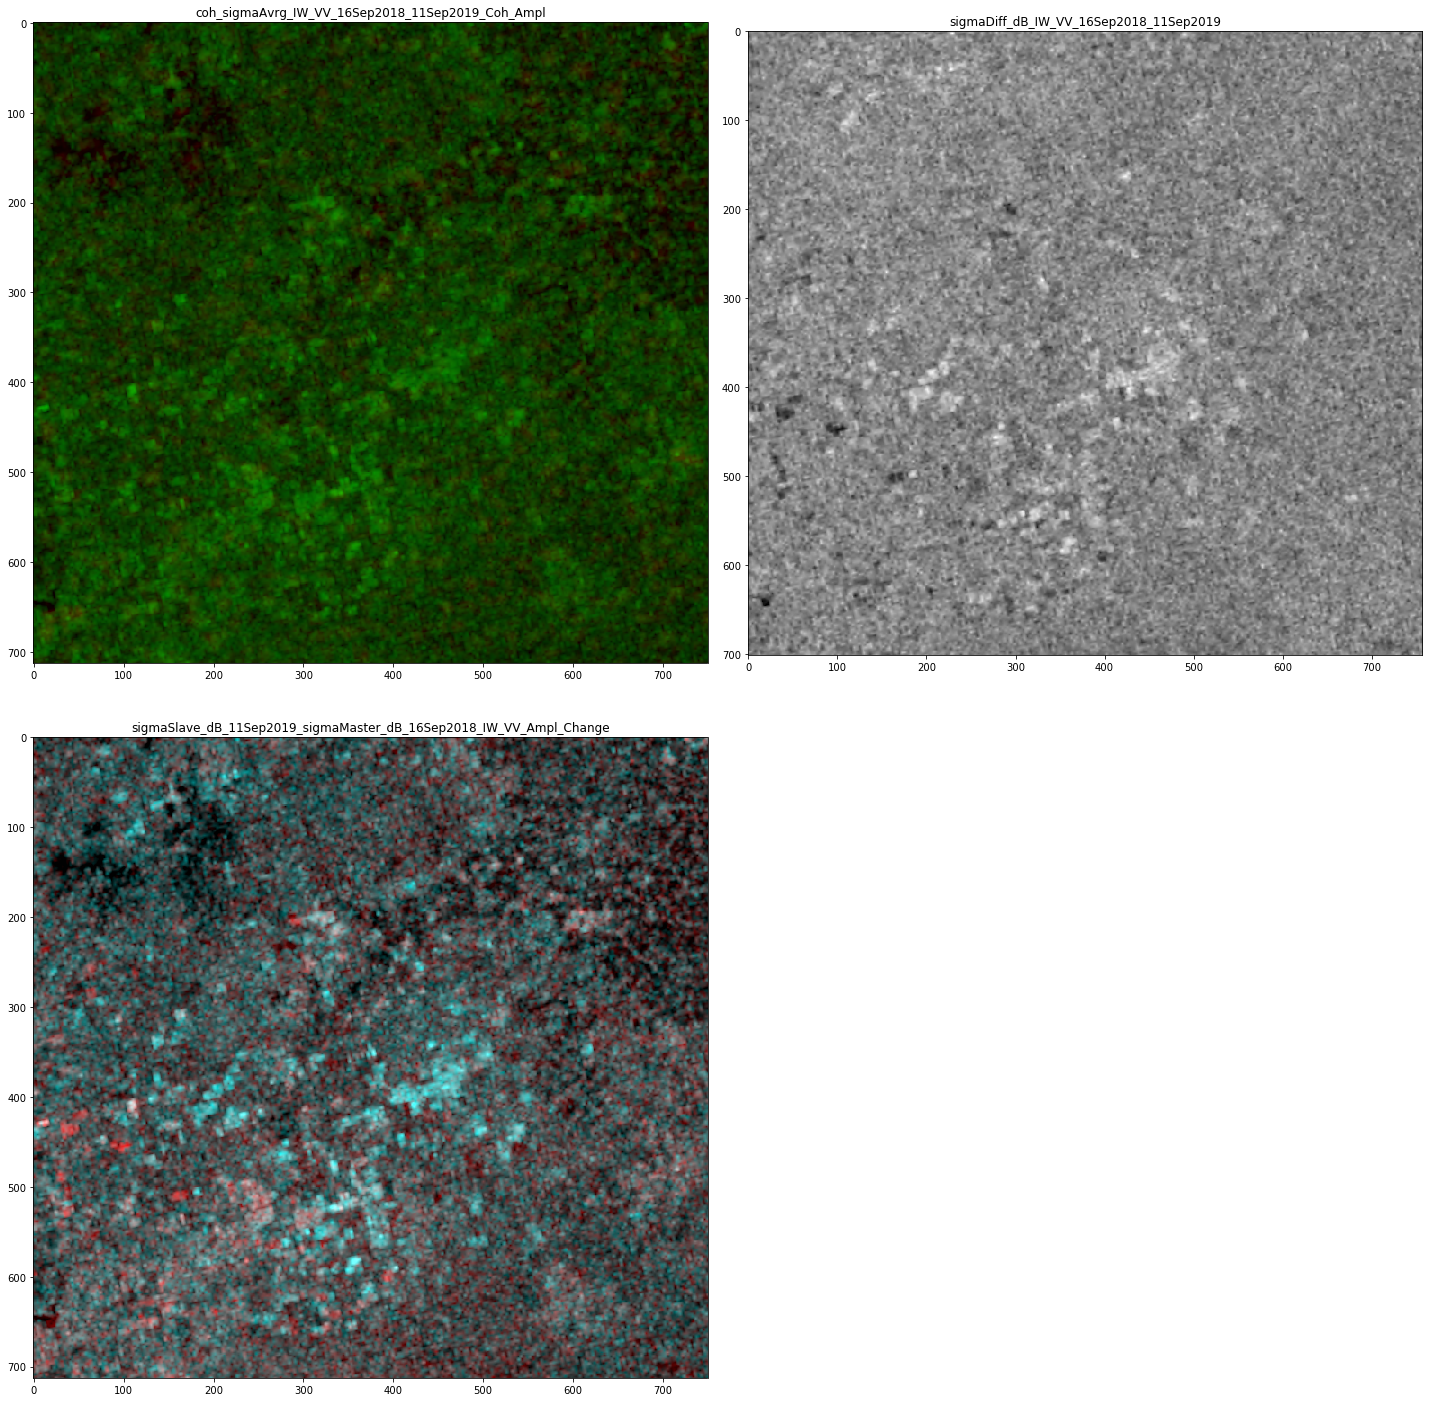

In [24]:
fig = plt.figure(figsize=(20,20))

i=1
for index, row in search_results[(search_results.title.str.contains('Ampl_Change')) |
                                 (search_results.title.str.contains('Coh_Ampl')) | 
                                 (search_results.title.str.contains('sigmaDiff'))].iterrows():
   
    print (row.title)
    
    img_data = vsi_download(row, 
                       aoi, 
                       username, 
                       api_key)

    print img_data.shape
    
    a=fig.add_subplot(2, 2, 0+i)
    a.set_title(row.title)
    width = 12
    height = 12
   
    if img_data.shape[2] == 4:
        
        data = np.dstack((img_data[:,:,0], 
                           img_data[:,:,1],
                           img_data[:,:,2])).astype(np.uint8) 

       
        #plt.figure(figsize=(width, height))
        img = Image.fromarray(data)
        imgplot = plt.imshow(img)

    else:
        
        data = img_data
    
        imgplot = plt.imshow(data.reshape(data.shape[0],data.shape[1]), cmap=plt.cm.gray) #,                          vmin=-5,                         vmax=15)

    i = i+1
        
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

## License

This work is licenced under a Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0) YOU ARE FREE TO:
- Share - copy and redistribute the material in any medium or format.
- Adapt - remix, transform, and built upon the material for any purpose, even commercially.

**UNDER THE FOLLOWING TERMS:**
- Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
- ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.